In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.integrate import odeint
import pandas as pd
import emcee
import corner
from math import factorial as fact
from scipy.optimize import minimize
from IPython.display import display, Math

Popolazione=60e6
NORM=3e5

df = pd.read_csv('dpc-covid19-ita-andamento-nazionale.csv')

df.drop('isolamento_domiciliare', inplace=True, axis=1)
df.drop('casi_da_sospetto_diagnostico', inplace=True, axis=1)
df.drop('casi_da_screening', inplace=True, axis=1)
df.drop('note', inplace=True, axis=1)
df.drop('note_test', inplace=True, axis=1)
df.drop('note_casi', inplace=True, axis=1)
df.drop('stato', inplace=True, axis=1)

giorni=np.linspace(1,len(df['data']),len(df['data']), dtype=int)

casi_testati_giornalieri=np.zeros(len( df['casi_testati']))

for i in range(1,len(casi_testati_giornalieri)):
    casi_testati_giornalieri[i]=df['casi_testati'][i]-df['casi_testati'][i-1]
    if(casi_testati_giornalieri[i]<0 or casi_testati_giornalieri[i]>5e5): 
        casi_testati_giornalieri[i]=casi_testati_giornalieri[i-1]
        
nuovi_deceduti=np.zeros(len( df['deceduti']))

for i in range(1,len(nuovi_deceduti)):
    nuovi_deceduti[i]=df['deceduti'][i]-df['deceduti'][i-1]
    if(nuovi_deceduti[i]<0 or nuovi_deceduti[i]>5000): 
        nuovi_deceduti[i]=nuovi_deceduti[i-1]
    
nuovi_pos_norm=np.where(casi_testati_giornalieri==0 , 0,np.array(df['nuovi_positivi'])/casi_testati_giornalieri*NORM)

    
df['casi_testati_giornalieri']=casi_testati_giornalieri
df['nuovi_deceduti']=nuovi_deceduti
df['nuovi_pos_norm']=nuovi_pos_norm

df


/tmp/ipykernel_2959/3727590513.py:42: RuntimeWarning: divide by zero encountered in true_divide
  nuovi_pos_norm=np.where(casi_testati_giornalieri==0 , 0,np.array(df['nuovi_positivi'])/casi_testati_giornalieri*NORM)


,data,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,casi_testati,ingressi_terapia_intensiva,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido,casi_testati_giornalieri,nuovi_deceduti,nuovi_pos_norm
0,2020-02-24T18:00:00,101,26,127,221,0,221,1,7,229,4324,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.000000
1,2020-02-25T18:00:00,114,35,150,311,90,93,1,10,322,8623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
2,2020-02-26T18:00:00,128,36,164,385,74,78,3,12,400,9587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
3,2020-02-27T18:00:00,248,56,304,588,203,250,45,17,650,12014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN
4,2020-02-28T18:00:00,345,64,409,821,233,238,46,21,888,15695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
861,2022-07-04T17:00:00,7648,303,7951,1019179,9236,36282,17617973,168604,18805756,227930923,59940922.0,27.0,8914455.0,9891301.0,93815731.0,134115192.0,33740.0,59.0,322602.252519
862,2022-07-05T17:00:00,8003,323,8326,1087272,68093,132274,17682801,168698,18938771,228395655,60032425.0,53.0,8930763.0,10008008.0,93878876.0,134516779.0,91503.0,94.0,433671.027179
863,2022-07-06T17:00:00,8220,325,8545,1146034,58762,107786,17733984,168770,19048788,228775690,60124960.0,43.0,8941235.0,10107553.0,93945315.0,134830375.0,92535.0,72.0,349443.994164
864,2022-07-07T17:00:00,8552,343,8895,1198697,52663,107240,17789613,168864,19157174,229153940,60213865.0,53.0,8952954.0,10204220.0,94003025.0,135150915.0,88905.0,94.0,361869.411169


In [18]:
plt.style.available  # scelgo uno stile e da quel momento in poi cambia il format

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [19]:
plt.style.use('seaborn-dark')   # scelgo uno stile e da quel momento in poi cambia il format

# Grafici vari

Mostriamo alcuni grafici relativi all'andamento del Covid. Vogliamo innanzitutto visualizzare l'andamento e cercare di comprendere (qui solo visivamente aka a cazzo di cane) 

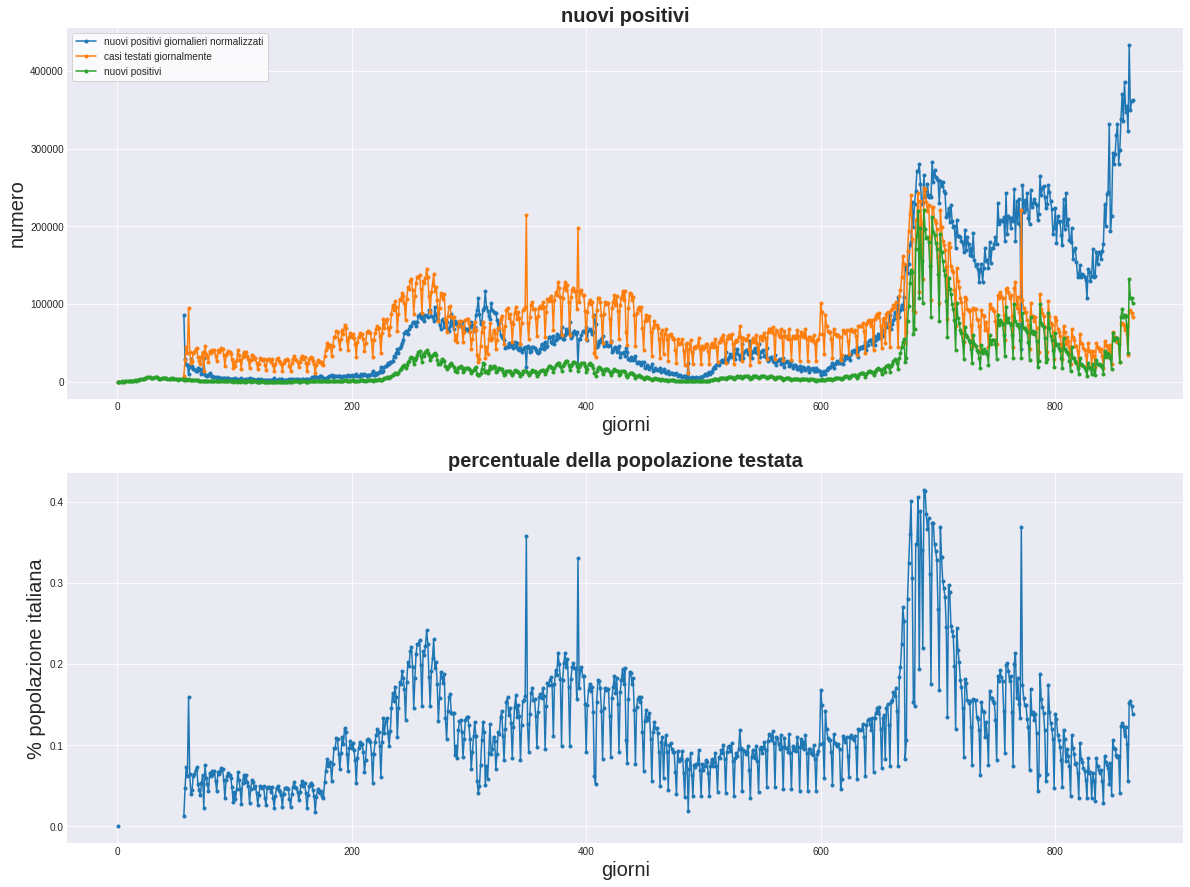

In [20]:


fig, axes=plt.subplots(2,1,figsize=(20,15))
ax=axes[0]
ax.plot(giorni,df['nuovi_pos_norm'], '.-',label='nuovi positivi giornalieri normalizzati')
ax.plot(giorni, df['casi_testati_giornalieri'],'.-', label='casi testati giornalmente')
ax.plot(giorni, df['nuovi_positivi'],'.-', label='nuovi positivi')
ax.set_title('nuovi positivi', fontsize=20, fontweight='bold')
ax.set_xlabel('giorni',fontsize=20)
ax.set_ylabel('numero',fontsize=20)
ax.grid(True)
ax.legend(frameon=True, facecolor='w', loc='upper left')

ax=axes[1]
ax.plot(giorni, df['casi_testati_giornalieri']/Popolazione*100,'.-', label='casi testati giornalmente')
ax.set_title('percentuale della popolazione testata', fontsize=20, fontweight='bold')
ax.set_xlabel('giorni',fontsize=20)
ax.set_ylabel('% popolazione italiana',fontsize=20)
ax.grid(True)
#ax.set_xlim(700, giorni[-1])
plt.show()

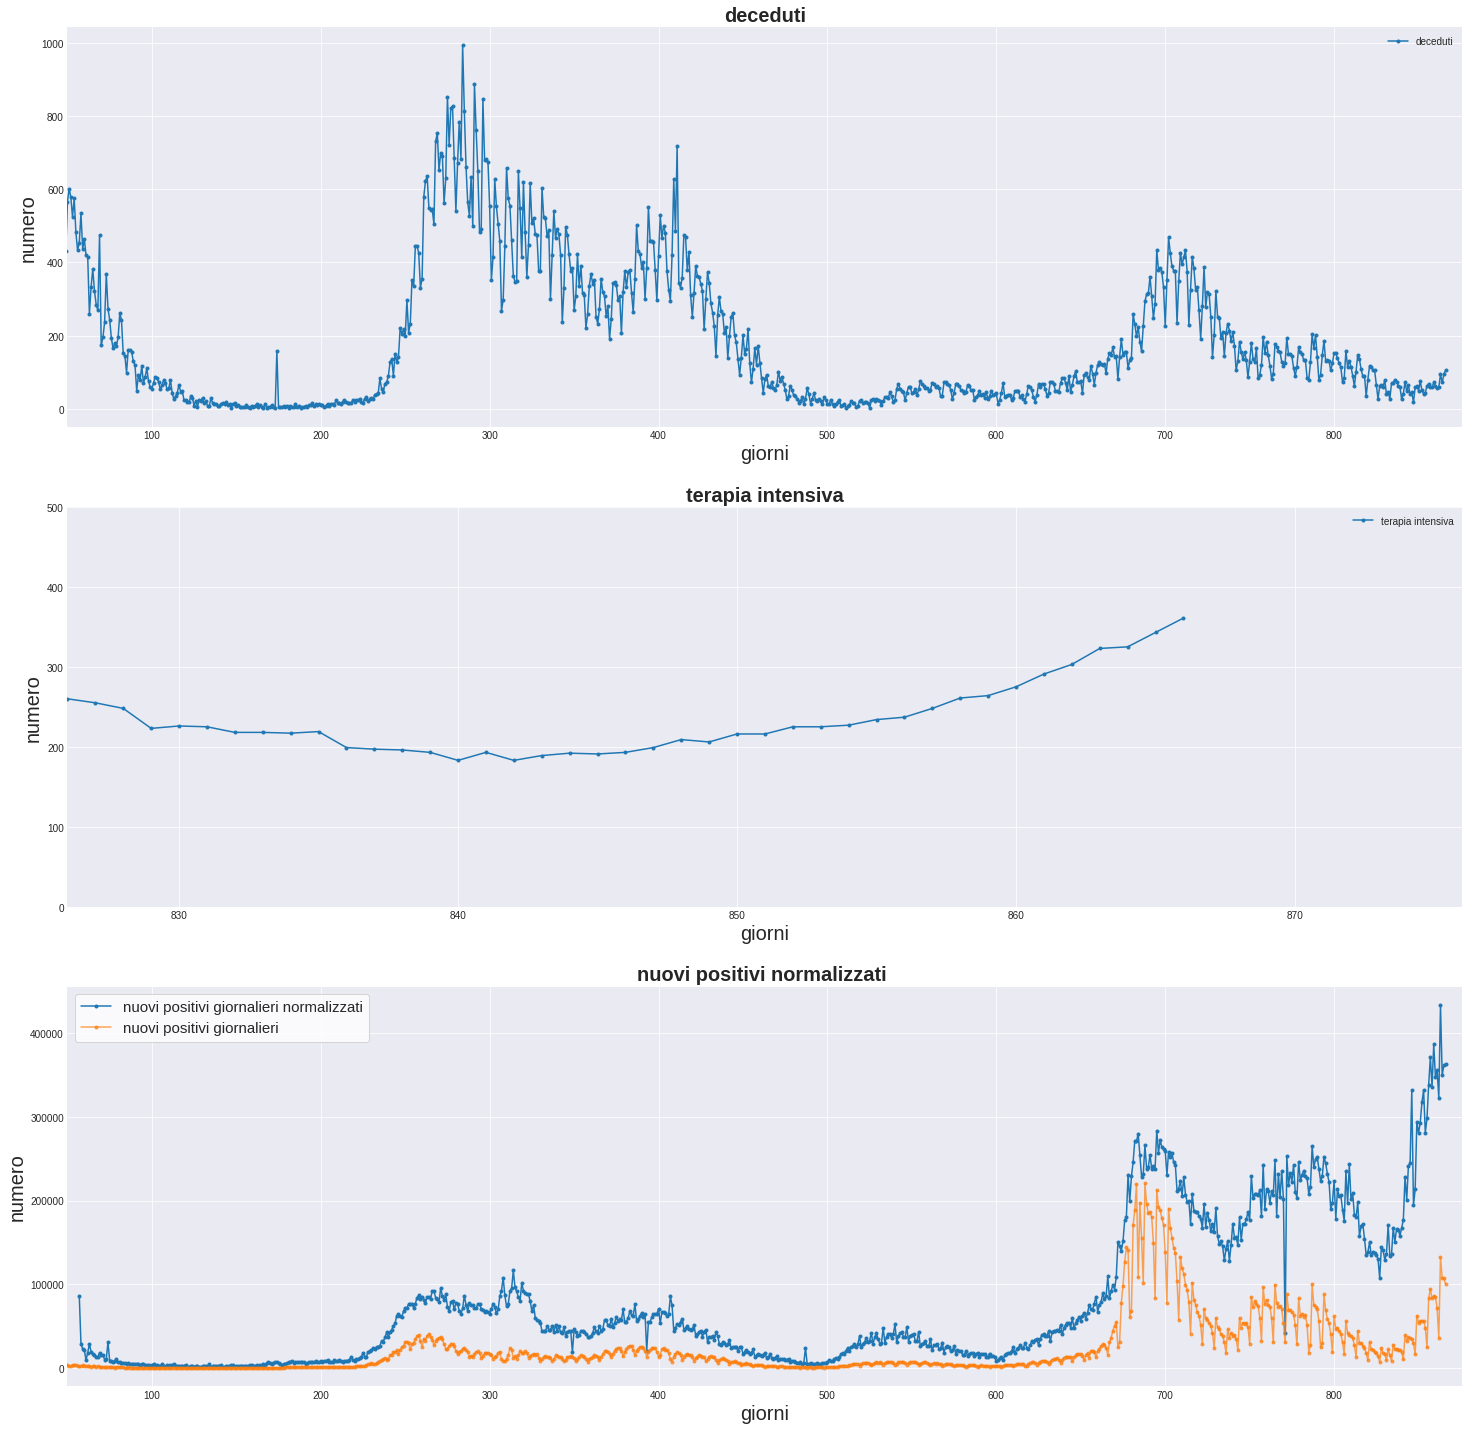

In [21]:
begin=50

fig, ax=plt.subplots(3,1,figsize=(25,25))
ax[0].plot(giorni,df['nuovi_deceduti'], '.-', label='deceduti')
ax[0].set_title('deceduti', fontsize=20, fontweight='bold')
ax[0].set_xlabel('giorni',fontsize=20)
ax[0].set_ylabel('numero',fontsize=20)
ax[0].grid(True)
ax[0].legend()
ax[0].set_xlim(50, giorni[-1]+10)

ax[1].plot(giorni, df['terapia_intensiva'], '.-', label='terapia intensiva')
ax[1].set_title('terapia intensiva', fontsize=20, fontweight='bold')
ax[1].set_xlabel('giorni',fontsize=20)
ax[1].set_ylabel('numero',fontsize=20)
ax[1].grid(True)
ax[1].legend()
#ax[1].set_xlim(50, giorni[-1]+10)
ax[1].set_xlim(giorni[-1]-40, giorni[-1]+10)
ax[1].set_ylim(0, 500)

ax[2].plot(giorni,df['nuovi_pos_norm'], '.-',label='nuovi positivi giornalieri normalizzati')
ax[2].plot(giorni,df['nuovi_positivi'], '.-',label='nuovi positivi giornalieri', alpha=0.7)
ax[2].set_title('nuovi positivi normalizzati ', fontsize=20, fontweight='bold')
ax[2].set_xlabel('giorni',fontsize=20)
ax[2].set_ylabel('numero',fontsize=20)
ax[2].legend(frameon=True,facecolor='w', loc='upper left', fontsize=15)
ax[2].grid(True)
ax[2].set_xlim(50, giorni[-1]+10)
plt.show()

Si osserva che l'ultimo picco nei nuovi positivi non è corrisposto ad un aumento delle terapie intensive o dei deceduti. Questo potrebbe essere causato dalla terza dose, dalla mutazione del virus (variante Omicron) e dall'inizio della stagione più calda (vero? boh forse si). Il confrtono non va tuttavia preso con troppa confidenza dato che comunque il numero di casi testati è esiguo (si parla di $0.1 \%$ della popolazione italiana), rendendo la statistica non troppo affidabile. Affidandoci però ai dati relativi alle terapie e ai deceduti si osserva comunque un'andamento decrescente

# Media settimanale

facciamo una media settimanale dei contagi e dei tamponi, sperando di avere un andamento più chiaro ed eventualmente una statistica più accurata successivamente



In [22]:
end=len(giorni)-len(giorni)%7
if (end%7!=0): print('error: non sto dividendo correttamente in settimane')

N_sett=int(end/7)
print(N_sett)
sett=np.arange(1, N_sett+1,1 )


terapia_intensiva=np.zeros(N_sett)
casi_testati_giornalieri=np.zeros(N_sett)
nuovi_deceduti=np.zeros(N_sett)
nuovi_positivi=np.zeros(N_sett)
nuovi_pos_norm_sett=np.zeros(N_sett)

for i in range(N_sett):
    casi_testati_giornalieri[i]=np.sum(df['casi_testati_giornalieri'][i*7:i*7+7])/7
    terapia_intensiva[i]=np.sum(df['terapia_intensiva'][i*7:i*7+7])/7
    nuovi_deceduti[i]=np.sum(df['nuovi_deceduti'][i*7:i*7+7])/7
    nuovi_positivi[i]=np.sum(df['nuovi_positivi'][i*7:i*7+7])/7
    nuovi_pos_norm_sett[i]=np.sum(df['nuovi_pos_norm'][i*7:i*7+7])/7

#nuovi_pos_norm_sett=np.where(casi_testati_giornalieri==0 , 0,np.array(nuovi_positivi)/casi_testati_giornalieri*NORM)

df_sett=pd.DataFrame({
    'giorno':sett*7,
    'sett':sett,
    'casi_testati_giornalieri': casi_testati_giornalieri,
    'terapia_intensiva': terapia_intensiva,
    'nuovi_deceduti': nuovi_deceduti,
    'nuovi_positivi': nuovi_positivi,
    'nuovi_pos_norm': nuovi_pos_norm_sett
        }
)

df_sett

123


,giorno,sett,casi_testati_giornalieri,terapia_intensiva,nuovi_deceduti,nuovi_positivi,nuovi_pos_norm
0,7,1,0.000000,66.000000,3.857143,240.857143,0.000000
1,14,2,0.000000,388.571429,47.428571,811.571429,0.000000
2,21,3,0.000000,1187.000000,206.142857,2481.714286,0.000000
3,28,4,0.000000,2455.285714,523.857143,4913.000000,0.000000
4,35,5,0.000000,3599.285714,757.571429,5507.285714,0.000000
...,...,...,...,...,...,...,...
118,833,119,34926.714286,230.428571,54.285714,16346.571429,137612.379223
119,840,120,38525.142857,200.571429,63.142857,20619.000000,158763.777358
120,847,121,40684.571429,191.428571,47.142857,31319.142857,231104.187402
121,854,122,51155.000000,217.714286,54.428571,50002.428571,287174.252428


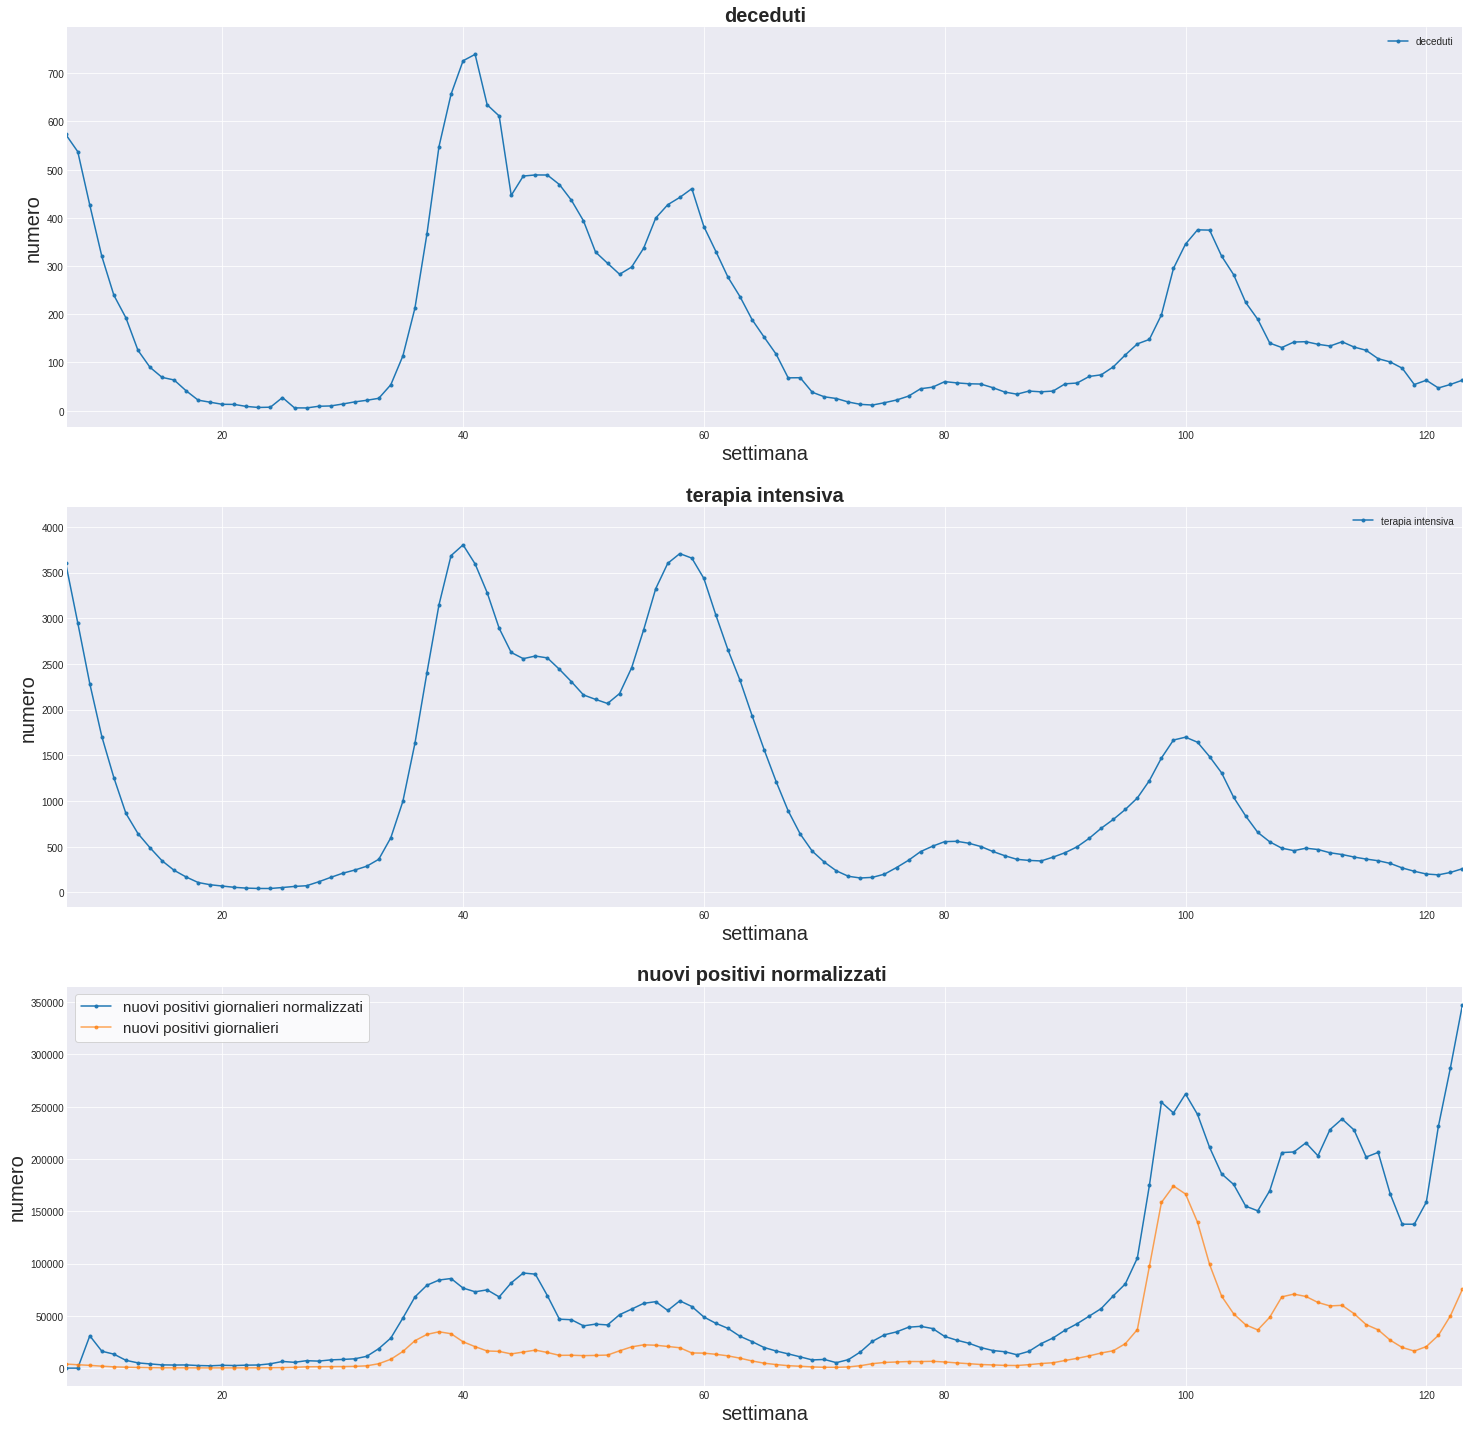

In [23]:
begin=50/7

fig, ax=plt.subplots(3,1,figsize=(25,25))
ax[0].plot(df_sett['sett'],df_sett['nuovi_deceduti'], '.-', label='deceduti')
ax[0].set_title('deceduti', fontsize=20, fontweight='bold')
ax[0].set_xlabel('settimana',fontsize=20)
ax[0].set_ylabel('numero',fontsize=20)
ax[0].grid(True)
ax[0].legend()
ax[0].set_xlim(begin, N_sett)

ax[1].plot(df_sett['sett'], df_sett['terapia_intensiva'], '.-', label='terapia intensiva')
ax[1].set_title('terapia intensiva', fontsize=20, fontweight='bold')
ax[1].set_xlabel('settimana',fontsize=20)
ax[1].set_ylabel('numero',fontsize=20)
ax[1].grid(True)
ax[1].legend()
ax[1].set_xlim(begin, N_sett)


ax[2].plot(df_sett['sett'],df_sett['nuovi_pos_norm'], '.-',label='nuovi positivi giornalieri normalizzati')
ax[2].plot(df_sett['sett'],df_sett['nuovi_positivi'], '.-',label='nuovi positivi giornalieri', alpha=0.7)
ax[2].set_title('nuovi positivi normalizzati ', fontsize=20, fontweight='bold')
ax[2].set_xlabel('settimana',fontsize=20)
ax[2].set_ylabel('numero',fontsize=20)
ax[2].legend(frameon=True,facecolor='w', loc='upper left', fontsize=15)
ax[2].grid(True)
ax[2].set_xlim(begin, N_sett)
plt.show()

# Modello SIR

Il modello SIR è un modello epidemiologico a compartimenti  dividendo la popolazione in tre categorie.
- Suscettibili (S): coloro che possono essere infettati
- Infetti (I)
- Guariti (G): coloro che sono stati infettati e non possono più ammalarsi. O sono guariti o sono stati abbracciati dalla grazie del grande spaghetto volante

Le equazioni differenziali che ne descrivono l'andamento sono:
$$
\begin{align}
\frac{dS}{dt}=-\frac{\beta}{N} I S \\
\frac{dI}{dt}=+\frac{\beta}{N} I S - \gamma I\\
\frac{dG}{dt}=+\gamma I
\end{align}
$$

Dove $\beta$ è il la probabilità di infezione per unità di tempo,  $\gamma$ è il rate di guarigione (quanti giorni ci mette un infetto per guarire o abbracciare gli spaghettosi tentacoli di sua spaghettosa bontà) e $R_0=\frac{\beta}{\gamma}$
è il numero medio di nuovi infetti a partire da un malato nel suo periodo di infettività al tempo iniziale (in generale potrebbe dipendere dal tempo. Per il momento lo assumiamo costante)

Per risolverle usiamo Odeint di scipy

In [24]:
#SOLVING SIR EQUATION
N=Popolazione
'''
def exp_I(y,t,gamma, r):  #defining SIR equation
    
    I=y 
    dI_dt=gamma*(r-1)*I
    dR_dt=gamma*I
    return dI_dt
'''
def I_solve(par, time):     #solving SIR equatuion
    I0,gamma,r=par
    I = I0*np.exp(gamma*(r-1)*(time-time[0]))
    return np.abs(I)

Mostriamo brevemente due soluzioni del modello SIR:
- $I_0=2 \quad R_0=1.5$: ci aspettiamo che il numero di infetti cresca, raggiunga un massimo e poi decresca (non ci sono più suscettibili da infettare)
- $I_0=1000000 \quad R_0=0.8$: ci aspettiamo che il numero di infetti decresca essendo $R_0<1$ (significa che ogni infetti durante il p-eriodo di positività infetta mediamente meno di un'altra persona)

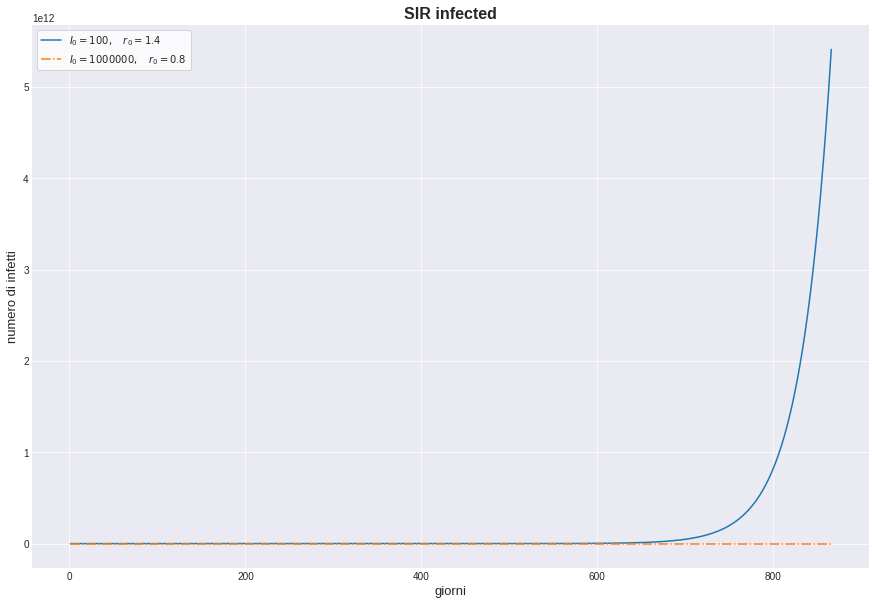

In [25]:
gamma=1./14
r_0_dangerous=1.4
beta_dangerous=r_0_dangerous*gamma
I_0=100

r_0_easy=0.8
beta_easy=r_0_easy*gamma
I_1=1000000

inf_1=I_solve([I_0, gamma, r_0_dangerous], giorni)
inf_2=I_solve([I_1, gamma, r_0_easy], giorni)

fig, ax=plt.subplots(1,1, figsize=(15,10))
ax.plot(giorni, inf_1, linestyle='-', label=f'$I_0={I_0}, \quad r_0={r_0_dangerous}$')
ax.plot(giorni, inf_2, linestyle='-.', label=f'$I_0={I_1}, \quad r_0={r_0_easy}$')
ax.set_ylabel('numero di infetti', fontsize=13)
ax.set_xlabel('giorni', fontsize=13)
ax.set_title('SIR infected', fontsize=16, fontweight='bold')
ax.grid(True)
ax.legend(frameon=True, facecolor='w')
plt.show()

Se $R_0<1$ i contagi decrescono. Viceversa i contagi aumentano fino a raggiungere un apice (in generale piuttosto elevato dato che la crescita iniziale è esponenziale)

# Statistica bayesiana e stima dei parametri del modello SIR

In [26]:
def log_likelihood(par, time, infected):    #par(S0,beta, gamma)
  
    return np.sum( -(infected-I_solve(par,time))**2/(2*I_solve(par,time))-0.5*np.log(2*np.pi*I_solve(par,time)) )

def log_prior(par):
    I0,gamma,r=par
    
    I0_min,I0_max=0,300000
    gamma_min,gamma_max=1./30,1./4
    r_min,r_max=0.5,2.5
    
    if I0<I0_min or I0>I0_max or gamma<gamma_min or gamma>gamma_max or r<r_min or r>r_max:

        return -np.inf 
    else:
        return np.log( 1./(I0_max-I0_min) * 1./(gamma_max-gamma_min) * 1./(r_max-r_min))

def log_posterior(par, time, infected):
    if np.isfinite(log_prior(par)):
        return  log_likelihood(par,time,infected)+log_prior(par)
    else:
        return -np.inf

In [27]:
# maximum likelihood estimation of parameters (not so efficent)

def Max_Likelihood(day_start, day_end, data):
    
    time=np.arange(day_start, day_end,1)                      # genero il vettore di tempi per risolvere odeint
    par=[10000, 0.07, 1]                                   #parametri più o meno sensati da cui far partire la ricerca del maximum likelihood
    infected=np.asarray(data[day_start:day_end].astype(int))  #fisso i dati da analizzare 

    #solving parameters with maximum likelihood
    np.random.seed(42)
    nll = lambda *args: -log_likelihood(*args)
    initial = np.array(par) + 0.1 * np.random.randn(3)
    soln = minimize(nll, initial, args=(time, infected))
    I_0_ml, gamma_ml, r_ml = soln.x

    print("Maximum likelihood estimates:")
    print("I_0 = {0:.3f}".format(I_0_ml))
    print("gamma = {0:.3f}".format(gamma_ml))
    print("R_0 = {0:.3f}".format(r_ml))
    print("beta = {0:.3f}".format(r_ml*gamma_ml))

    #plotting
    fig,ax=plt.subplots(figsize=(15,8))
    ax.plot(time, infected)
    ax.plot(time,infected, "k", alpha=0.3, lw=3, label="data")
    ax.plot(time, I_solve([I_0_ml, gamma_ml, r_ml], time), ":k", label="ML")
    ax.legend(fontsize=14)
    ax.set_xlabel("x")
    ax.set_ylabel("y");
    ax.grid(True)
    

In [28]:
# uses the emcee alghoritm to eseem parameters 

def Emcee_sampler(day_start, day_end, data, MCsteps=1000, nwalkers=50):
    
    time=np.arange(day_start, day_end,1)                      # genero il vettore di tempi per risolvere odeint
    par=[10000, 0.07, 1]                                   #parametri più o meno sensati da cui far partire la ricerca del maximum likelihood
    infected=np.asarray(data[day_start:day_end].astype(int))  #fisso i dati da analizzare 


    ndim=3
    p0=np.random.rand(nwalkers,ndim)   #punti di partenza dei random walk (generati casualmente all'interno dello spazio dei parametri)
    p0[:,0]=90+p0[:,0]*20           #spazio i pt di partenza in modo omogeneo nell'intervallo dello spazio dei parametri
    p0[:,1]=1./25+p0[:,1]*0.02
    p0[:,2]=1+p0[:,2]

    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_posterior, args=(time, infected)
    )
    sampler.run_mcmc(p0, MCsteps, progress=True);
    return sampler

In [29]:
#print plots of the emcee estimation
import csv

def Print_Plots(sampler, day_start, day_end, data):
    
    time=np.arange(day_start, day_end,1)                      # genero il vettore di tempi per risolvere odeint
    par=[10000, 0.07, 0.11]                                   #parametri più o meno sensati da cui far partire la ricerca del maximum likelihood
    infected=np.asarray(data[day_start:day_end].astype(int))  #fisso i dati da analizzare 

    
    #plot the markov chain path for every walker
    fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
    samples = sampler.get_chain()
    labels = [r"$I_0$", r"$\gamma$", r"R_0", ]
    ndim=3

    
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i], fontsize=16)
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number", fontsize=16);
    plt.suptitle("walkers markov chains' path", fontsize=20, fontweight='bold')
    
    
    #plot the poterior distribution for every parameter
    flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)

    fig = corner.corner(
        flat_samples, labels=labels,
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True, title_kwargs={"fontsize": 15}
    );
    

    #print the parameters and their error as the center of the distribution and the the percentile
    param_emcee=np.zeros(ndim)
    err_mean_param=np.zeros(ndim)

    file = open('exp_fit_I_gamma_R.csv','w')
    writer = csv.writer(file)
    
    print('parameters esteem with emcee quantiles')
    #percentiles=[ [16, 50, 84], [10, 40, 50],[10,40,60]  ]
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i],[16, 50, 84])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        output=[mcmc[1], q[0], q[1]]
        writer.writerow(output)
        param_emcee[i]=mcmc[1]
        err_mean_param[i]=(q[1]+q[0])/2
        display(Math(txt))

    file.close()


    
    #plot the data and the SIR model with emcee parameters estimation
    fig,ax=plt.subplots(figsize=(15,8))
    ax.plot(time,infected, "o--", alpha=0.3, lw=3, label="data")
    ax.plot(time, I_solve(param_emcee, time), "--", label=f"optimal parameters fit, $R_0={param_emcee[2]}$")
    ax.legend(fontsize=14, frameon=True, facecolor='w')
    ax.set_title('Infected vs emcee model esteem', fontsize=20, fontweight='bold')
    ax.set_xlabel("days", fontsize=16)
    ax.set_ylabel("number of infected", fontsize=16);
    ax.grid(True)






-------------------------------

---------------------------
### giorni 825-last day

In [30]:
# scelgo i giorni da analizzare 

day_start, day_end=825, len(giorni)
time=np.arange(day_start, day_end,1)  # genero il vettore di tempi per risolvere odeint

print(len(giorni))
#scelgo il dataset da usare: principalmente df['categoria'], df_sett['categoria'], con 'categoria ' 
data=df['nuovi_pos_norm']

866


In [31]:
sampler=Emcee_sampler(day_start, day_end, data, 2000, 200)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:17<00:00, 113.42it/s]


parameters esteem with emcee quantiles


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

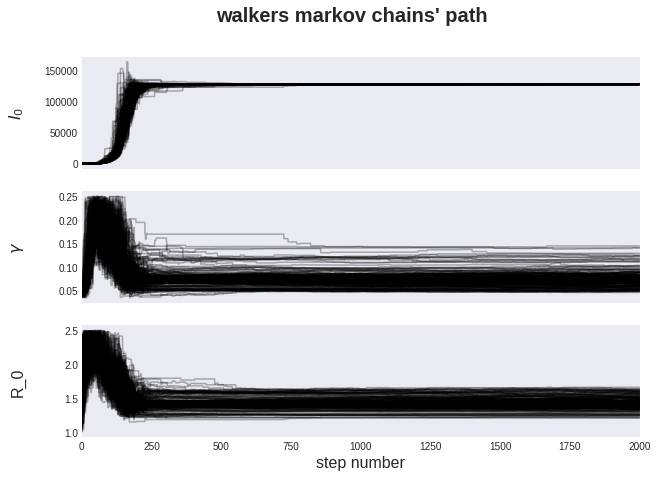

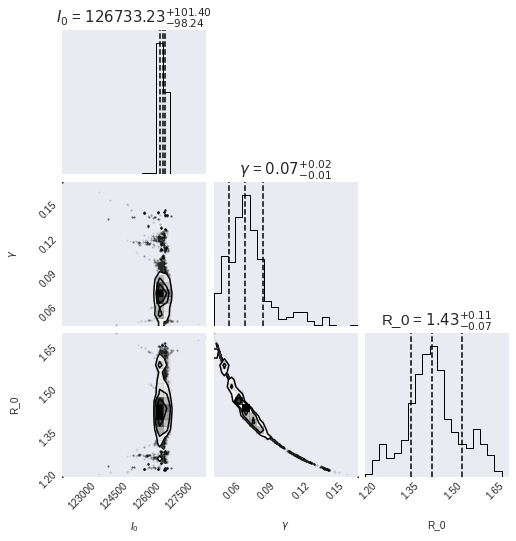

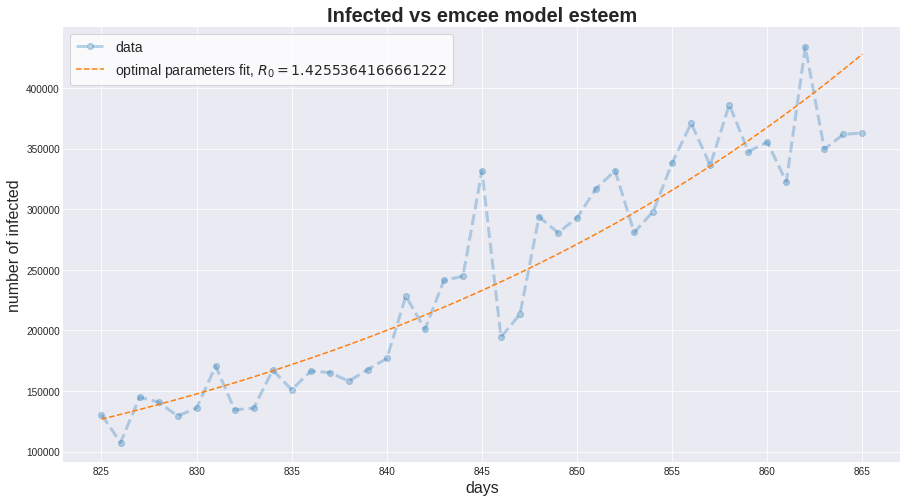

In [32]:
Print_Plots(sampler, day_start, day_end, data)

La curva è riiniziata a crescere ed effettivamente la stima di $R_0$ mostra che $R_0>1$

In [19]:
R_exp=1.397
sigma_exp=0.1

R_sir=1.53
sigma_sir=0.4

R_mean=(R_exp/sigma_exp+R_sir/sigma_sir)/(1/sigma_exp+1/sigma_sir)
sigma_mean=np.sqrt(1/(1/sigma_exp**2+1/sigma_sir**2))

txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
txt = txt.format(R_mean, sigma_mean, sigma_mean, 'R_m')

display(Math(txt))


<IPython.core.display.Math object>